# Visualization

Let's load first an image


In [25]:
import tifffile

filename = '../data/example.tif'
img = tifffile.imread(filename)
print("The shape of the array is [depth x channels x height x width]", img.shape)

The shape of the array is [depth x channels x height x width] (25, 2, 400, 400)


We can display a 2D image using imshow from matplotlib. To display the two channels together, we create a RGB image by coding a small function 'to_rgb' than takes as an input an image with 2 channels with channel being the first index and return an images with 3 channels with channels as last index.

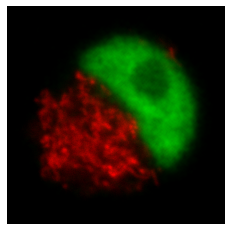

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def to_rgb(array):
    ''' Convert the a cxy 2 channel image to a xyc rgb image'''
    shp = (array.shape[1],array.shape[2],3)
    rgb = np.zeros(shp,dtype=array.dtype)
    rgb[:,:,0] = array[0,:,:]
    rgb[:,:,1] = array[1,:,:]
    return rgb

plt.imshow(to_rgb(img[12,:,:,:]))
plt.axis('off')
plt.show()

Let's add a widget to explore the z serie. We'll reuse here the image already loaded and the function to_rgb to convert the image plane by plane. We need to code an update function that refresh the displayed image and used it in the inteact function which will display a widget slider controling the z plane.

In [29]:
from ipywidgets import *

slider = widgets.IntSlider(value=1,min=1,max=25,step=1,description="Z",disabled=False)

def update(z):
    if z < img.shape[0]:
        plt.imshow(to_rgb(img[z-1,:,:,:]))
        plt.axis('off')
        plt.title(f"Slice: {z}")

interact(update,z=slider);



interactive(children=(IntSlider(value=1, description='Z', max=25, min=1), Output()), _dom_classes=('widget-int…

## Cropping


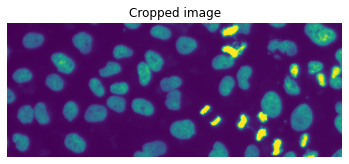

In [34]:
import tifffile
import matplotlib.pyplot as plt

img = tifffile.imread('../data/nuclei.tif')
# To crop the image, we use the index of the rows and columns we want to extract 
# from the image using the syntax img[row1:row2,column1:column2]
crop = img[0:200,0:500]
plt.imshow(crop)
plt.title('Cropped image')
plt.axis('off')
plt.show()

## Histogram
Histograms provide a quick insight on the distribion of the intensity in the image.

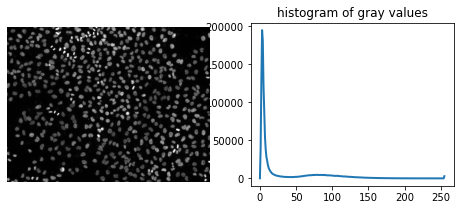

In [16]:
import matplotlib.pyplot as plt
from skimage.exposure import histogram

filename = '../data/nuclei.tif'
img = tifffile.imread(filename)
hist, hist_centers  = histogram(img)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
fig.show()

## 3D rendering of volumes
Often images acquired in microsopcy are tri-dimensional and we need a way to visualize them in their original full dimensionnality.

### Using ipyvolume
We can use ipyvolume to render interactively images in a notebook. This will run only in a browser. We install ipyvolume in conda using: 
```conda install -c conda-forge ipyvolume```

In [ ]:
#import ipyvolume as ipv
#ipv.figure()
#ipv.volshow(img[:,1,:,:])

## Using napari

Napari is a visualization program designed for browsing, annotating, and analyzing large multi-dimensional images.
```conda install -c conda-forge napari ```
We are in a notebook and we need to initialize the GUI interface before by running (```%gui qt```) before hand as it takes a few seconds to initialize:

In [17]:
%gui qt

We first visualize our volume with its 2 channels:

In [19]:
import tifffile
import napari

# Load a 3D image
filename = '../data/example.tif'
img = tifffile.imread(filename)

# Create a Viewer and add an image here with the two channels and scaling
with napari.gui_qt():
    napari.view_image(img, channel_axis=1, name=['dapi', 'fitc'], scale=[10,1,1])

Let's add an iso-surface. We first smooth the surface using a Gaussian filter and then compute a triangulation of the isosurface using the marching cubes algorithm.

In [20]:
from skimage import measure
from skimage import filters
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

iso_val = 64 # iso value / threshold
vol = filters.gaussian(np.squeeze(img[:,1,:,:]),2,preserve_range=True)
verts, faces, normals, values = measure.marching_cubes_lewiner(vol, iso_val)
surface = (verts, faces, values)

with napari.gui_qt():
    # create a Viewer and add an image here with the two channels and scaling
    viewer = napari.view_image(img,channel_axis=1,name=['dapi', 'fitc'],scale=[10,1,1])
    viewer.add_surface(surface,colormap='jet',scale=[10,1,1])